In [1]:
import stumpy
import pickle
import numpy as np
import time
import sklearn.metrics as metrics

from pipelinetools import *
from multiprocessing import Pool
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
dataset = np.load("../datasets/ieee/open_2tab.npz")
their_direction = dataset['direction']
their_time = dataset['time']
their_label = dataset['label']

traces_train = load_traces('transformer_train')

In [3]:
def append_trace(trace_time, trace_direction, new_trace):
    
    new_direction = [None] * len(new_trace)
    new_time = [None] * len(new_trace)
    
    
    previous_time = trace_time[-1]
    
    for k in range(len(new_trace)):
        packet = new_trace[k]
        new_time[k] = abs(packet) + previous_time
        new_direction[k] = np.sign(packet)
    
    return trace_time + new_time, trace_direction + new_direction, 

In [4]:
# creates datasets using our data with a single "closed-world" sample and num_random-1 "open-world" samples
# num-traces samples are created

def make_merged_ieee_format(traces, num_random, num_traces):
    our_time = np.empty((num_traces, 10000))
    our_direction = np.empty((num_traces, 10000))
    our_label = np.empty((num_traces, 51))
    
    for i in tqdm(range(num_traces)):
        trace_direction = []
        trace_time = [0]
    
        # select a random class as the "true" class label
        true_id = random.choice([*range(50)])
        true_idx = random.randint(0,len(traces[true_id])-1)
        true_trace = traces[true_id][true_idx]
        true_pos = random.randint(0, num_random-1)
        
        # index for true trace in list of traces
        random_idx = [random.randint(0,len(traces[-1])-1) for i in range(num_random)]
        random_traces = [traces[-1][idx] for idx in random_idx]
        
        
        for j in range(num_random):
            if j == true_pos:
                trace_time, trace_direction  = append_trace(trace_time, trace_direction, true_trace)
            else:   
                trace_time, trace_direction  = append_trace(trace_time, trace_direction, random_traces.pop(-1))
        
        trace_label = [0] * 51
        trace_label[50] = 1
        trace_label[true_id] = 1
        
        trace_time.pop(0)
        if len(trace_time) < 10000:
            padding = [0] * (10000 - len(trace_time))
            trace_time = trace_time + padding
            trace_direction = trace_direction + padding
        
        our_time[i] = np.asarray(trace_time[:10000])
        our_direction[i] = np.asarray(trace_direction[:10000])
        our_label[i] = np.asarray(trace_label)
    
    return our_time, our_direction, our_label    

In [ ]:
our_time, our_direction, our_label = make_merged_ieee_format(traces_train, 2, 64000)

our_dataset = {}
our_dataset['time'] = our_time
our_dataset['direction'] = our_direction
our_dataset['label'] = our_label

  8%|███                                  | 5214/64000 [00:50<08:14, 118.92it/s]

In [ ]:
np.save('../results/multi-open_3tab.npz', our_dataset)

In [115]:
print(our_time.shape)
print(our_direction.shape)
print(our_label.shape)

(1, 10000)
(1, 10000)
(1, 51)


In [120]:
print(our_label[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1.]


In [116]:
print(their_time.shape)
print(their_direction.shape)
print(their_label.shape)

(64000, 10000)
(64000, 10000)
(64000, 101)


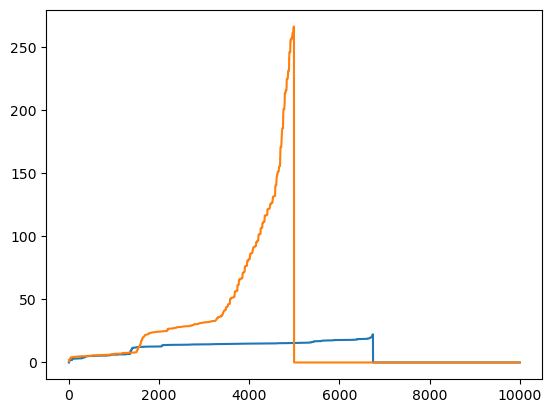

In [119]:
plt.plot(our_time[0])
plt.plot(their_time[0])